<a href="https://colab.research.google.com/github/americanthinker/vector_search_applications_PUBLIC/blob/master/Copy_of_1_Preprocess_Data_Week1_COLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebooks is part of Week 1 of the course: Vector Search Applications w/ LLMs.  Authored by Chris Sanchez.

# Project 1.1

# Overview

Welcome to Week 1 of this course!  Over the course of two weeks we will build an application that utilizes both keyword and vector search as core components of a Retrieval Augmented Generation (RAG) system integrated with an OpenAI LLM. At a high level we will work with the following tech stack to build out each system component:


*   Python 3.10
*   SentenceTransformers: to convert text into vectors as well as rerank returned resuls
* OpenSearch: will act as both our keyword and vector database
* Llamaindex: will be our "glue" code which provides much of the heavy lifting
* OpenAI ChatGPT-3.5-Turbo: Our LLM of choice (mainly because it's free) for answer synthesis and generation
* Streamlit: We'll wrap up everything together for display to users through a Streamlit UI



<div>
<img src="https://www.python.org/static/community_logos/python-logo-master-v3-TM-flattened.png" style="text-align:center" width="300"/>
<img src="https://huggingface.co/spaces/sentence-transformers/README/resolve/main/sbertLogo.png" width="180"/>
<img src="https://d2908q01vomqb2.cloudfront.net/ca3512f4dfa95a03169c5a670a4c91a19b3077b4/2021/07/12/opensearch_logo_1000x500.png" width="200"/>
</div>
<div>
<img src="https://d1tlzifd8jdoy4.cloudfront.net/wp-content/uploads/2023/03/eyecatch-llamdaindex.png" width="200"/>
<img src="https://blogs.sap.com/wp-content/uploads/2023/08/1681142315open-ai-logo-1.png" width="250"/>
<img src="https://streamlit.io/images/brand/streamlit-logo-primary-colormark-darktext.svg" width="200"/>
</div>

# Problem
Explanation of what RAG solves

# Approach
As a reminder we will divide the approach to building this system into four parts over two weeks-

#### Week One
* Part 1 (THIS NOTEBOOK):
  * Data ingest and preprocessing
  * Convert text into vectors
* Part 2:
  * Index data on OpenSearch database
  * Benchmark retrieval results  

#### Week Two
* Part 3:
  * Add a reranker to the mix (new benchmark)
  * Integrate with ChatGPT-Turbo
* Part 4:
  * Benchmark overall system
  * Display results in Streamlit



Let's get cracking!

## Install libraries for this notebook

In [1]:
#visualization tool for displaying long load/processing times
!pip install tqdm --quiet
#data processing
!pip install pandas --quiet
#workhorse for converting text into embeddings/vectors
!pip install sentence-transformers==2.2.2 --quiet
#data framework for LLM applications
!pip install llama-index==0.8.41 --quiet
#logging output
!pip install loguru==0.7.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.1/868.1 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 16.1 MB/s eta 

## Download preprocessing file (helper code) from public repo

In [2]:
!curl -o preprocessing.py https://raw.githubusercontent.com/americanthinker/vector_search_applications_PUBLIC/master/preprocessing.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12776  100 12776    0     0  45333      0 --:--:-- --:--:-- --:--:-- 45304


## Download data from publicly accessible s3 bucket
Total download size should be about 25 MB

In [3]:
!curl -o impact_theory_data.json https://vector-search-applications-data.s3.us-west-2.amazonaws.com/impact_theory_data.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25.3M  100 25.3M    0     0  23.7M      0  0:00:01  0:00:01 --:--:-- 23.7M


In [4]:
#standard libraries
import json
import os
from collections import defaultdict
from typing import List, Dict, Tuple

#external libraries
from tqdm import tqdm
import pandas as pd
import numpy as np
from preprocessing import FileIO, Vectorizor, Splitters
from sentence_transformers import SentenceTransformer
from llama_index.text_splitter import SentenceSplitter
from concurrent.futures import ProcessPoolExecutor, as_completed

## Step 1 -->  Import Podcast Transcripts

The hard part of this project i.e. collecting the data and wrangling it into an acceptable format has already been completed for you.  Yes, there is value in completing that step yourself, not the least of which is gaining a better understanding of the nuances and format of the data.  But, given our compressed time window, we will focus our efforts on the actual search application components of this project.

### The Data
The data - 385 podcast episodes to be exact - we will use for this project is a collection of transcribed podcast/youtube episodes of <a href="https://www.youtube.com/@TomBilyeu" target="_blank">The Impact Theory</a>

<div>
  <a href="https://www.youtube.com/@TomBilyeu" target="_blank">
  <img src="https://impacttheory.com/wp-content/uploads/2018/11/impact-theory-logo.png" style="text-align:center" width="500"/>
</div>

In [68]:
#root folder on Google Colab is: /content/
root_folder = '/content/'
data_path = os.path.join(root_folder, 'impact_theory_data.json')

In [6]:
#should see 385 unique podcast entries
with open(data_path) as f:
    data =  json.load(f)
len(data)

385

Let's take a peek at what a podcast entry looks like.  We'll look at one of the shorter episodes.

In [7]:
data[22]

{'author': 'Tom Bilyeu',
 'title': 'Will The US Dollar COLLAPSE? - China & Russia Declaring ECONOMIC WAR On America | Ray Dalio',
 'video_id': '4LOdU151RJE',
 'playlist_id': 'PL8qcvQ7Byc3OJ02hbWJbHWePh4XEg3cvo',
 'channel_id': 'UCnYMOamNKLGVlJgRUbamveA',
 'description': 'No description provided',
 'keywords': [],
 'length': 1057,
 'publish_date': '06-17-2023',
 'thumbnail_url': 'https://i.ytimg.com/vi/4LOdU151RJE/hq720.jpg',
 'views': 346851,
 'age_restricted': False,
 'content': "Right now, one of the things that has me the most unnerved is the attack on the dollar. So you've got the BRICS nations, for people that haven't heard that acronym before, Brazil, Russia, India, China, and South Africa are getting together. And I know this has been going on for quite some time, so I don't know if I should be overly paranoid about that in this moment or not. But again, going back to those indicators that point to a transition from phase five to phase six, do you think there's anything that we 

We can see that each entry contains episode metadata (title, author, episode length, etc.) as well as the main show i.e. the "content" field which contains the entire episode transcript. It may not jump out at you now, but we'll soon see that the "video_id" is one of the most important fields of the bunch, because it provides us with a unique identifier for each podcast episode.

Let's quickly get some rough statistics on the length of the content for each episode. We'll count (roughly) the number of words in each episode by splitting on whitespace.

In [8]:
lens = [len(d['content'].split()) for d in data]
df = pd.DataFrame(lens, columns=['Lengths'])
df.describe()

,Lengths
count,385.000000
mean,12884.654545
std,7741.439730
min,1819.000000
25%,7891.000000
50%,9899.000000
75%,16860.000000
max,48502.000000


In [9]:
mean_word_count = 12884
token_ratio = 1.3
approx_token_count = mean_word_count * token_ratio
print(f'Looks like the mean word count is about 13K words, which corresponds to a rough token count of {approx_token_count}')

Looks like the mean word count is about 13K words, which corresponds to a rough token count of 16749.2


### Chunking:
The open source embedding models that we will be working with have a max_sequence_length parameter far less than 16K tokens.  Even the OpenAI *text-embedding-ada-002* model has a max token length of 8,191 (as of Sept. 2023).  In order to effectively process the content of our podcast episodes, we'll need to decide on a **Chunking Strategy**.

## Step 2 -->  Split Text into Sentences - LlamaIndex

![Chunking Strategy]( 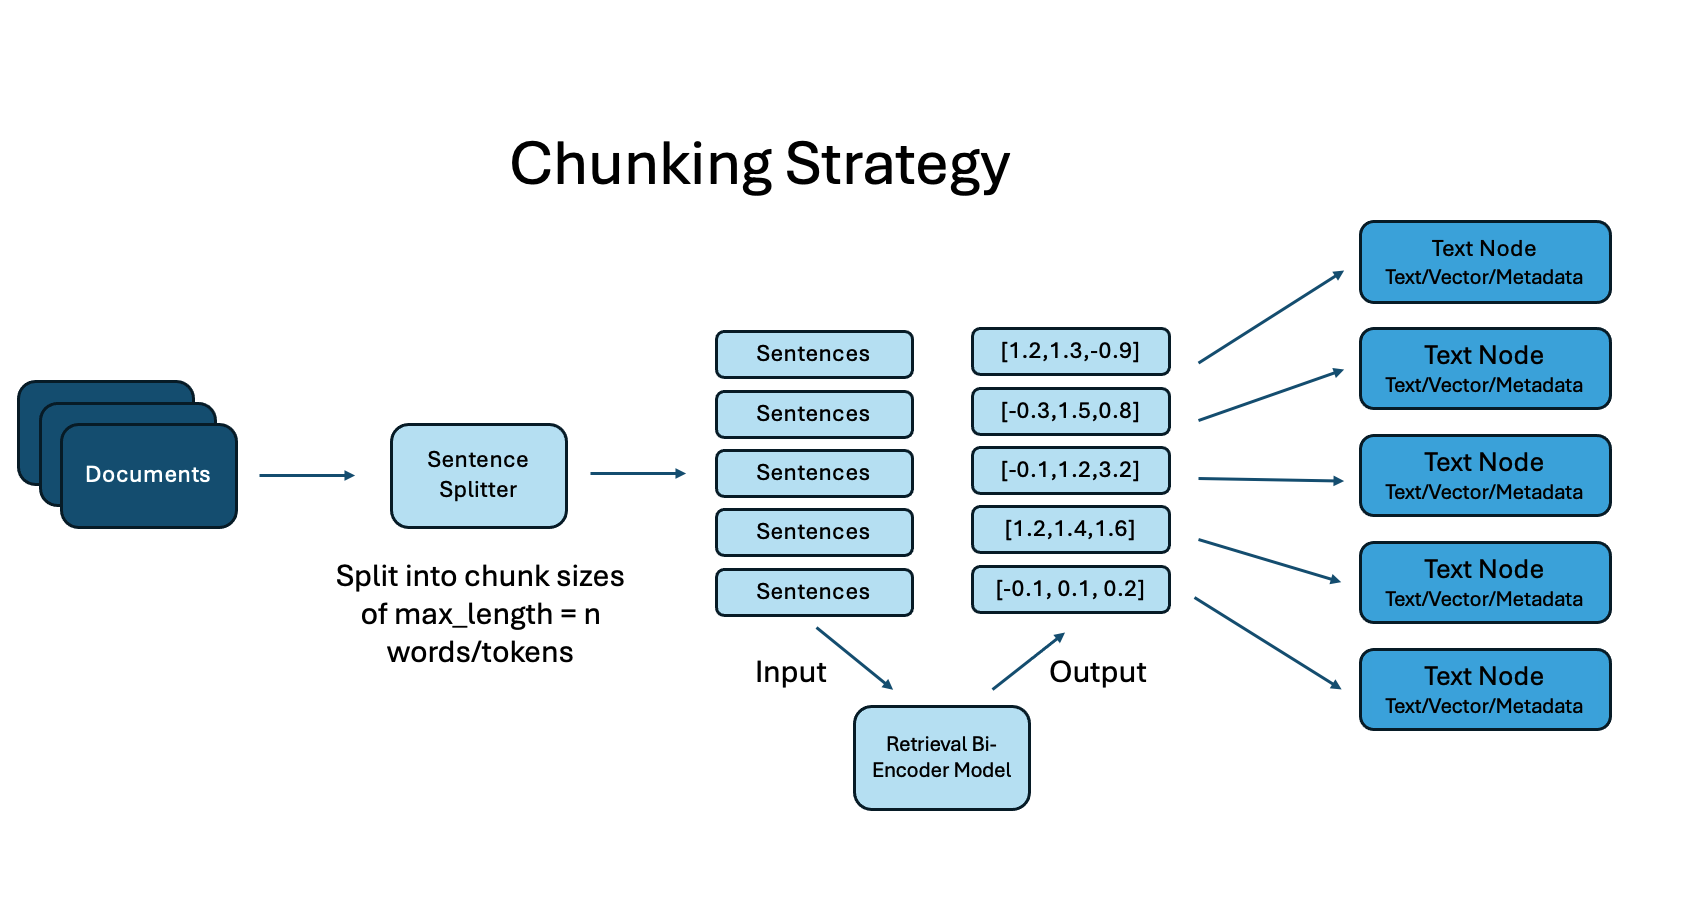)

In [ ]:
#TODO: Dig into why text_splitter is using NLTK tokenizer under the hood.

In [12]:
#discussion on chunk size
chunk_size = 196
text_splitter = SentenceSplitter(chunk_size=chunk_size, chunk_overlap=20)

### Assignment 1.1 - Chunking the Data

In [11]:
def split_corpus( corpus: List[dict],
                  text_splitter: SentenceSplitter,
                  content_field: str='content'
                  ) -> Dict[str, List[str]]:
    '''
    Given a corpus of "documents" with text content, this function splits the
    content field into chunks sizes as specified by the text_splitter arg.
    '''
    ### INSTRUCTIONS
    '''
    1. Instantiate an empty dictionary
    2. Iterate over the corpus of podcast episodes
    3. Extact the video_id from each episode
    4. Split the "content" field using the text_splitter
    5. Create entry in new dictionary with key as video_id and value as the split content
    '''
    ########################
    # START YOUR CODE HERE #
    ########################


In [13]:
splitter = Splitters()
split_dict = splitter.easy_split_corpus(data[:10], text_splitter)

Docs: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


In [14]:
lens = [len(split_dict[key]) for key in split_dict]
sum(lens)

1890

## Step 3 -->  Encode Chunks as Vectors (Transfer to Google Colab)

### 3a.) SentenceTransformers

In [15]:
model_path = 'thenlper/gte-base'
vectorizer = Vectorizor(model_name_or_path=model_path)
model = SentenceTransformer(model_path)

### Assignment 1.2 - Converting Text into Vectors

In [21]:
def encode_from_dict( splits_dict: dict,
                      model: SentenceTransformer,
                      device: str='cuda:0'
                      ) -> Dict[str, Tuple[str, np.array]]:
        '''
        Encode text to vectors from a dictionary where digits are keys,
        with each key representing an entire document (podcast)
        '''

        ### INSTRUCTIONS
        '''
        1. Instantiate an empty dictionary
        2. Iterate over the splits_dict
        3. Extact the text_chunks associated with each key (video_id)
        4. Call the encode method of the passed in model and encode the entire list of text chunks
        5. Create entry in new dictionary with key as video_id and a list of combined text_chunks
           and associated vectors (use zip for this step)
        '''
        ########################
        # START YOUR CODE HERE #
        ########################
        # Output will be a single dictionary with keys as video_ids and each value being a tuple of
        # text_chunks and vector representations.

In [17]:
test = encode_from_dict(split_dict, model)

Docs: 100%|██████████| 10/10 [00:28<00:00,  2.82s/it]


In [20]:
# test[list(test.keys())[0]][0]

In [22]:
%%time
# vectorizor = Vectorizor(model_name_or_path=model_path)
# merged_dict = vectorizer.encode_from_dict(split_dict, device='cuda:0')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 9.06 µs


### Assignment 1.3 - Combining Metadata with Text/Vectors

In [63]:
def join_metadata(corpus: Dict[str, dict], text_vector_dict: Dict[str, Tuple[str, np.array]]) -> List[dict]:
    '''
    Combined episode metadata from original corpus with text/vectors from text_vector_dict.
    Creates a new dictionary for each text/vector combination.
    '''
    joined_documents = []
    for video_id in text_vector_dict.keys():
      meta = corpus[video_id]
      for i, text_tuple in enumerate(text_vector_dict[video_id]):
        doc = {k:v for k,v in meta.items() if k != 'content'}
        doc['content'] = text_tuple[0]
        doc['content_embedding'] = text_tuple[1].tolist()
        doc['doc_id'] = video_id + '_' + str(i)
        joined_documents.append(doc)
    return joined_documents

    ### INSTRUCTIONS
    '''
    1. Iterate over the text_vector_dict
    2. Using the video_id key grab the associated episode from the original corpus in a variable labeled "meta"
    3. Enumerate over the value of text_vector_dict[video_id] extracting an index, and the text/vector tuple
    4. For each tuple create a new dictionary and insert all fields from the meta variable except for the "content" field
    5. Create a "content" field in the dictionary and insert the text from the tuple
    6. Create a "content_embedding" field in the dictionary and insert the vector from the tuple - convert it into a list before inserting
    7. Create a "doc_id" field in the dictionary by combining the video_id and the index from step 3
    8. Append each dictionary into the "joined_documents" list
    '''
    ########################
    # START YOUR CODE HERE #
    ########################
    # joined_documents = []

    # Output will be a list of dictionaries that includes content, content_embedding, and associated metadata.
    # This is data is now ready to be indexed

In [42]:
def create_hash_table(data: List[dict]) -> List[Dict[str, dict]]:
  hasht = {d['video_id']:d for d in data}
  return hasht

In [32]:
hasht = create_hash_table(data)

In [36]:
subset = ['mrND5lSPEQU', 'nXJBccSwtB8', '6KJhM7Pg5EA', 'IQefdkl8PfY', 'sl3XhHs6ggs', '60U-wLfB8iU', 'gzNLzqI5oTE', '9I39boHZYjI', 'Tigt75AcLLA', 'IK9lN__kBXs']
subset = [d for d in data if d['video_id'] in subset]
hasht_subset = create_hash_table(subset)

In [64]:
docs = join_metadata(hasht_subset, test)
len(docs)

1890

In [59]:
sum([len(test[k]) for k in test.keys()])

1890

In [66]:
vectorizor = Vectorizor(model_path)
docs = vectorizer.join_metadata_version2(corpus=hasht_subset, text_vector_dict=test)
len(docs)

1890

We can save our dataset using the conventient "save_as_parquet" method from our FileIO Class.  Try it out here to see how it works and then move on to the final Assignment for this notebook.

In [67]:
io = FileIO()
#root folder was previously defined at the beginning of the notebook
outpath = os.path.join(root_folder, f'impact_theory_gte_{chunk_size}.parquet')
io.save_as_parquet(file_path=outpath, data=docs, overwrite=True)

2023-10-17 22:53:49.190 | INFO     | preprocessing:save_as_parquet:34 - DataFrame saved as parquet file here: /content/impact_theory_get_196.parquet


In [69]:
#Verify that you can reload data
data_with_vectors = io.load_parquet(file_path=outpath)

Shape of data: (1890, 15)
Memory Usage: 0.2+ MB


In [70]:
len(data_with_vectors), type(data_with_vectors)

(1890, list)

### Assignment 1.4 - Creating Datasets with Multiple Chunk Lengths

In [76]:
chunk_sizes = [128, 196, 256, 384]
def create_datasets(chunk_sizes: List[int],
                    corpus: Dict[str, dict],
                    text_splitter: SentenceSplitter,
                    model: SentenceTransformer,
                    device: str,
                    file_outpath_prefix: str
                    ) -> None:
    io = FileIO()
    for size in chunk_sizes:
      text_splitter = SentenceSplitter(chunk_size=size, chunk_overlap=20)
      split_texts = splitter.easy_split_corpus(corpus, text_splitter)
      vector_dicts = vectorizer.encode_from_dict(split_texts, model, device)
      joined_docs = vectorizer.join_metadata_version2(corpus, vector_dicts)
      io.save_as_parquet(file_path=f'{file_outpath_prefix}_{size}.parquet', data=joined_docs, overwrite=True)

In [77]:
%%time
create_datasets(chunk_sizes, hasht_subset, text_splitter, model, 'cuda:0', 'impact_theory_test')

Docs:   0%|          | 0/10 [00:00<?, ?it/s]


TypeError: ignored

## Step - 3.1 --> OPTIONAL: OpenAI Ada Embeddings

In [ ]:
openai.api_key = os.environ['OPENAI_API_KEY']
model = "text-embedding-ada-002"
from openai.embeddings_utils import get_embedding, cosine_similarity
#get cost first
tokenizer = Tokenizer(model_type="cl100k_base", price=0.001)

# cost = tokenizer.get_cost(text_chunks)

#### Working around OpenAI rate limits

In [ ]:
#split text_chunks into roughly 1 million tokens total per group
for num in range(0,43000,6000):
    chunks = text_chunks[num:num+6000]
    cost = tokenizer.get_cost(chunks)


Total Tokens: 890642	Cost: 0.891
Total Tokens: 889149	Cost: 0.889
Total Tokens: 892516	Cost: 0.893
Total Tokens: 887084	Cost: 0.887
Total Tokens: 892144	Cost: 0.892
Total Tokens: 887583	Cost: 0.888
Total Tokens: 876077	Cost: 0.876
Total Tokens: 126477	Cost: 0.126


In [ ]:
# openai.Embedding.create(text_chunks[:2], engine=model)

In [ ]:
# %%time
# embeddings = []
# for num in range(0,43000,6000):
#     chunks = text_chunks[num:num+6000]
#     results = openai.Embedding.create(input=chunks, engine=model)
#     embeddings.append(results)
#     time.sleep(60)

In [ ]:
vectors = results['data']
vectors = [vec['embedding'] for vec in vectors]
len(vectors)